# Germeval 2019: Pre-processing & baseline

```
pip install scikit-multilearn
```

Information for Subtask B: Exactly one parent is assigned to a child genre. The underlying hierarchy is a forest. The most specific writing genre of a book is not necessarily a leaf node.

In [1]:
# Change this
DATASET_DIR = '/Volumes/data/repo/data/germeval2019-1/GermEval2019T1_final_test_phase'

In [33]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import codecs
import re
from collections import defaultdict

import spacy
from spacy.util import minibatch, compounding
import pickle
from lxml import etree
from datetime import datetime

from sklearn.metrics import f1_score

from nltk.stem.snowball import SnowballStemmer

In [34]:
np.random.seed(0)

In [35]:
class Book(object):
    def __init__(self, title, body, _copyright, categories, authors, publish_date, isbn, url):
        self.title = title
        self.text = body
        if body == None:
            #sys.stderr.write('WARNING: Empty body, setting to "empty"\n')
            self.text = "empty"
        self._copyright = _copyright
        self.categories = categories
        
        self.authors = authors
        self.publish_date = publish_date
        self.isbn = isbn
        self.url = url


    # method 2 in Blurb: get leaf-labels
    def get_task_labels(self, level=0):
        if isinstance(self.categories, dict):
            for topic in self.categories:
                if self.categories[topic]['d'] == level:
                    yield topic
                
    def get_task1_labels(self):
        for topic in self.categories:
            if self.categories[topic]['d'] == 0:
                yield topic

    def get_task2_labels(self):
        for topic in self.categories:
            if self.categories[topic]['d'] == 1:
                yield topic

    
    #def to_df_item(self, available_cats, with_text=True, levels=[0]):
    def to_df_item(self, with_text=True):
        # categories_level = name: level
        
        age_in_years = max(round((datetime.today() - datetime.strptime(self.publish_date, '%Y-%m-%d')).days / 365), 1)
        
        words = self.text.split()
        words_len = np.array([len(w) for w in words])
        
        authors_str = ';'.join(self.authors)
        
        doc = {
            'isbn': self.isbn,
            'title': self.title,
            'title_words': len(self.title.split()),
            'author_count': len(self.authors),
            'authors': ';'.join(self.authors),
            'authors_academic': 1 if 'dr.' in authors_str.lower() or 'prof.' in authors_str.lower() else 0,
            'copyright': self._copyright,
            'publish_date': self.publish_date,
            'age': age_in_years,
            'text_words': len(words),
            'text_words_10': round(len(words) / 10), 
            'word_len_mean': round(np.mean(words_len)),
            'word_len_median': round(np.median(words_len)),
            'word_len_max': np.max(words_len),           
            
        }
        
        if with_text:
            doc['text'] = self.text
        
        return doc
    
    def to_df_item_labels(self, categories_level):
        
        # categories
        #[('-' * level) + label for label, level in task_labels.items()]
        
        labels = {('-' * level) + label: 0 for label, level in categories_level.items()}  # init with 0
        for cat, v in self.categories.items():
            k = ('-' * v['d']) + cat
            
            if k in labels: 
                labels[k] = 1
                
        #doc.update(cats)
        #return doc
        
        return labels

In [36]:
 def getMatrix(books):
    m = []
    for b in books:
        #row = [b.title, b._copyright, b.publish_date, b.isbn, ' '.join(b.authors), ' '.join(b.getTop_n(n)), b.getTask1Labels()]
        row = [b.text]# doing this with only text for first baseline
        labelcolumns = [0] * len(task1_labels)
        for l in b.get_task1_labels():
            labelcolumns[task1label2pos[l]] = 1
        row.extend(labelcolumns)
        m.append(row)

    return m

def parseXML(xml, task_labels=dict()):  # task_labels = set(), task2_labels = set
    #global alllabels
    #global taks1labels
    
    tree = None
    xmlParser = etree.XMLParser(strip_cdata=False, resolve_entities=False, encoding='utf-8', remove_comments=True)
    try:
        tree = etree.parse(xml, parser=xmlParser).getroot()
    except etree.XMLSyntaxError:
        # it wasn't proper xml; wrap tags around it
        lines = codecs.open(xml, 'r').readlines()
        lines = ['<rootnode>'] + lines + ['</rootnode>']
        xmlstring = re.sub('&', '&amp;', '\n'.join(lines))
        tree = etree.fromstring(xmlstring)

    maxNrAuthors = 0
    #global maxNrAuthors

    books = []
    for book in tree:
        title, body, _cr, auths, pubdata, isbn, url = ['_'] * 7
        cats = defaultdict(lambda: defaultdict(str))
        
        for node in book:
            if node.tag == 'title':
                title = node.text
            elif node.tag == 'body':
                body = node.text
            elif node.tag == 'copyright':
                _cr = node.text
            elif node.tag == 'categories':
                # creating a dict?               
                
                # category
                for subnode in node:
                    # topic d = 0
                    for ssubnode in subnode:
                        # topic d = 1
                        if ssubnode.tag == 'topic':
                            cats[ssubnode.text]['d'] = int(ssubnode.get('d'))
                            if 'label' in ssubnode.attrib:
                                cats[ssubnode.text]['label'] = ssubnode.get('label')
            elif node.tag == 'authors':
                if node.text:  # was empty for some...
                    auths = [x.strip() for x in node.text.split(',')]
                    if len(auths) > maxNrAuthors:
                        maxNrAuthors = len(auths)
            elif node.tag == 'published':
                pubdata = node.text
            elif node.tag == 'isbn':
                isbn = node.text
            elif node.tag == 'url':
                url = node.text
        b = Book(title, body, _cr, cats, auths, pubdata, isbn, url)
        
        task_labels.update({label: 0 for label in b.get_task_labels(0)})
        
        # task2
        task_labels.update({label: 1 for label in b.get_task_labels(1)})
        task_labels.update({label: 2 for label in b.get_task_labels(2)})
        
        
        books.append(b)

    return books, task_labels
       

In [37]:
trainbooks, task_labels = parseXML(os.path.join(DATASET_DIR, 'blurbs_train.txt'))
validationbooks, task_labels = parseXML(os.path.join(DATASET_DIR, 'blurbs_dev.txt'), task_labels)


In [38]:
task1_labels = [label for label, level in task_labels.items() if level == 0]
task1_labels

['Literatur & Unterhaltung',
 'Ratgeber',
 'Künste',
 'Sachbuch',
 'Glaube & Ethik',
 'Kinderbuch & Jugendbuch',
 'Ganzheitliches Bewusstsein',
 'Architektur & Garten']

In [39]:
task_labels
trainbooks[0].__dict__

{'title': 'Die Klinik',
 'text': 'Ein Blick hinter die Kulissen eines Krankenhauses vom Autor der Bestseller "Der Medicus" und "Der Medicus von Saragossa". Der Wissenschaftler Adam Silverstone, der kubanische Aristokrat Rafael Meomartino und der Farbige Spurgeon Robinson - sie sind drei grundverschiedene Klinik-Ärzte, die unter der unerbittlichen Aufsicht von Dr. Longwood praktizieren. Eines Tages stirbt eine Patientin, und Dr. Longwood wittert einen Behandlungsfehler. Sofort macht er sich auf die Suche nach einem Schuldigen, dem er die Verantwortung in die Schuhe schieben könnte ...',
 '_copyright': '(c) Verlagsgruppe Random House GmbH',
 'categories': defaultdict(<function __main__.parseXML.<locals>.<lambda>()>,
             {'Literatur & Unterhaltung': defaultdict(str, {'d': 0}),
              'Romane & Erzählungen': defaultdict(str,
                          {'d': 1, 'label': 'True'})}),
 'authors': ['Noah Gordon'],
 'publish_date': '2013-12-02',
 'isbn': '9783641136291',
 'url': '

In [41]:
with_text = True

doc_cols = list(trainbooks[0].to_df_item(with_text).keys())
label_cols = list(trainbooks[0].to_df_item_labels(task_labels).keys())

train_df = pd.DataFrame([{**d.to_df_item(with_text), **d.to_df_item_labels(task_labels)} for d in trainbooks])
val_df = pd.DataFrame([{**d.to_df_item(with_text), **d.to_df_item_labels(task_labels)} for d in validationbooks])

train_df = train_df.reindex(columns=doc_cols + label_cols)
val_df = val_df.reindex(columns=doc_cols + label_cols)

val_df.head()

,isbn,title,title_words,author_count,authors,authors_academic,copyright,publish_date,age,text_words,...,--Baumaterialien,--Griechische Literatur,--Utopie,--Street Art,--Handwerk Holz Grundlagenwissen,--Stadtplanung,--Reden & Glückwünsche,--Fahrzeuge / Technik,--Bibel in gerechter Sprache,--Antiquitäten
0,9783579074030,Selbstständig werden im Glauben,4,1,Hans-Martin Lübking,0,(c) Verlagsgruppe Random House GmbH,2013-07-22,6,113,...,0,0,0,0,0,0,0,0,0,0
1,9783570380093,Das Buch der Schatten - Schwarze Seelen,7,1,Cate Tiernan,0,(c) Verlagsgruppe Random House GmbH,2013-06-10,6,73,...,0,0,0,0,0,0,0,0,0,0
2,9783453422650,Die Jesuitin von Lissabon,4,1,Titus Müller,0,(c) Verlagsgruppe Random House GmbH,2018-11-12,1,83,...,0,0,0,0,0,0,0,0,0,0
3,9783453702479,Die Essenz der Lehre Buddhas,5,1,Dalai Lama,0,(c) Verlagsgruppe Random House GmbH,2014-02-10,5,56,...,0,0,0,0,0,0,0,0,0,0
4,9783641048198,Das letzte Kind,3,1,John Hart,0,(c) Verlagsgruppe Random House GmbH,2010-08-13,9,111,...,0,0,0,0,0,0,0,0,0,0


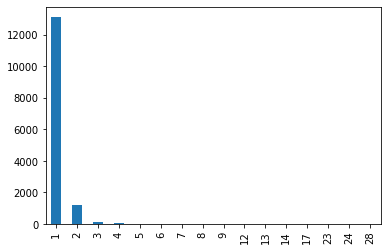

In [45]:
#df.groupby('author_count')['col_A'].agg(['min', 'max', 'mean','median']).transpose().plot(kind='bar')
#df.groupby('author_count')['author_count'].agg(['count'])
train_df['author_count'].value_counts().sort_index().plot(kind='bar')

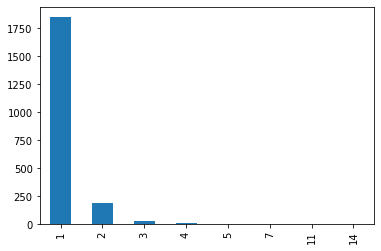

In [12]:
val_df['author_count'].value_counts().sort_index().plot(kind='bar')

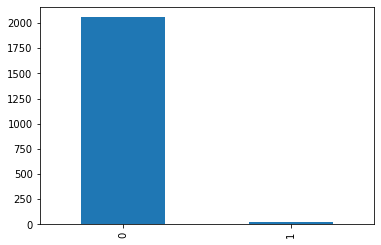

In [13]:
val_df['authors_academic'].value_counts().sort_index().plot(kind='bar')

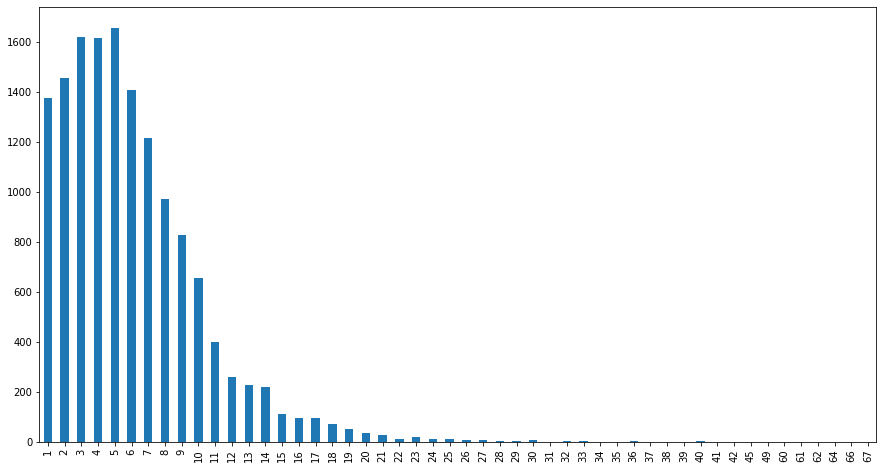

In [14]:
train_df['age'].value_counts().sort_index()[:50].plot(kind='bar',figsize=(15,8))

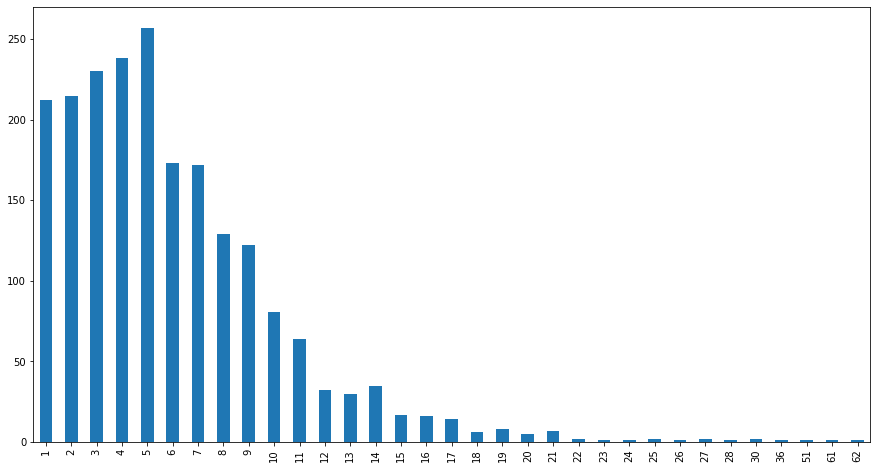

In [15]:
val_df['age'].value_counts().sort_index()[:50].plot(kind='bar',figsize=(15,8))

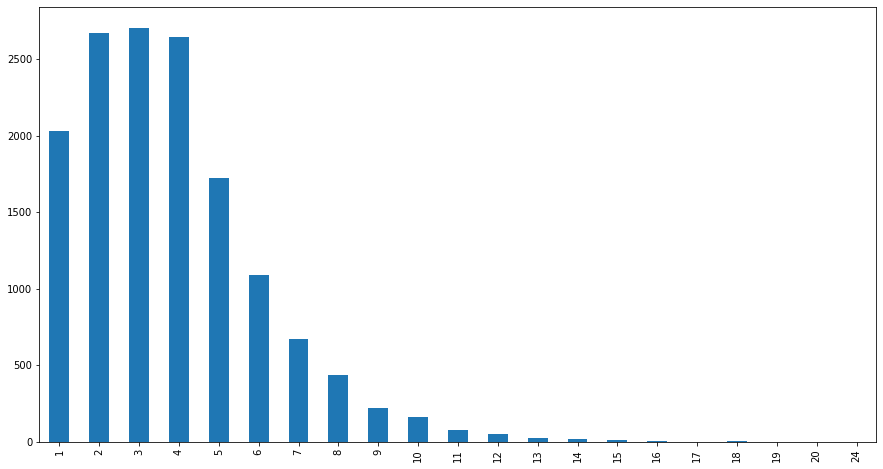

In [16]:
train_df['title_words'].value_counts().sort_index().plot(kind='bar',figsize=(15,8))

In [17]:
# BERT sequence limit? only 63 items > 256 ==> no problem

words_limit = 300
ds = train_df[train_df['text_words'] > words_limit]

print(f'DOCS with words > {words_limit}: {len(ds)} / {len(train_df)}')

ds['text_words'].value_counts().sort_index() #.plot(kind='bar',figsize=(15,8))

DOCS with words > 300: 36 / 14548


301    1
303    1
307    1
309    1
311    1
312    1
313    2
314    1
316    2
319    1
323    1
324    1
328    1
331    1
332    1
334    1
336    1
337    1
339    1
352    1
353    1
355    1
356    1
358    1
386    1
389    2
392    1
399    1
427    1
438    1
440    1
485    1
571    1
Name: text_words, dtype: int64

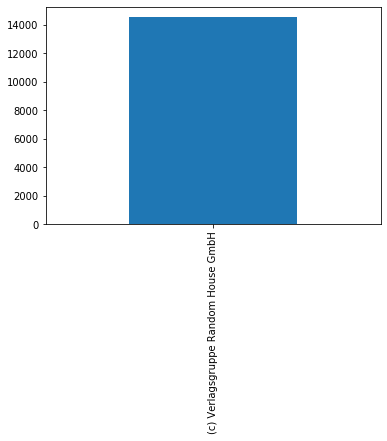

In [18]:
train_df['copyright'].value_counts().sort_index().plot(kind='bar')

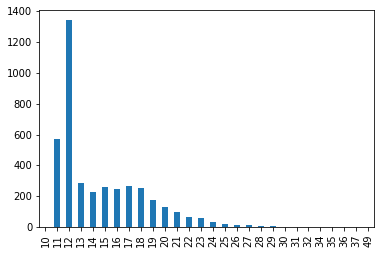

In [19]:
val_df['word_len_mean'].value_counts().sort_index().plot(kind='bar')
val_df['word_len_median'].value_counts().sort_index().plot(kind='bar')
val_df['word_len_max'].value_counts().sort_index().plot(kind='bar')


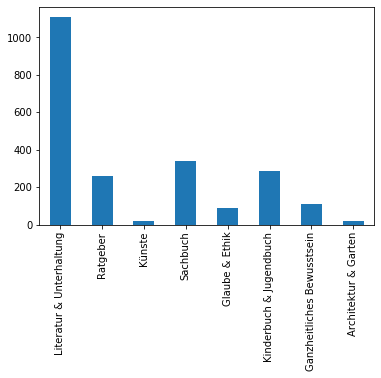

In [20]:
# Most frequent labels
val_df[task1_labels].sum().plot(kind='bar')

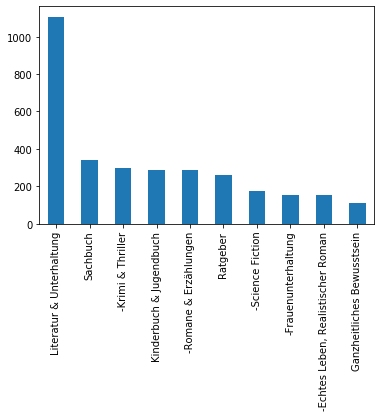

In [21]:
val_df[label_cols].sum().sort_values(ascending=False)[:10].plot(kind='bar')

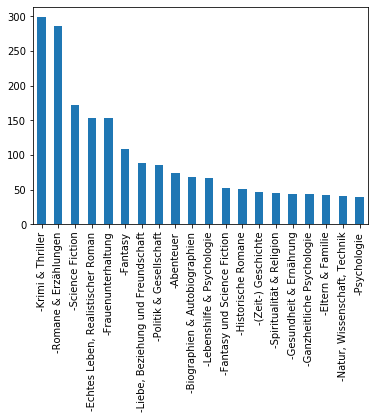

In [22]:
# 2nd level
val_df[[l for l in label_cols if l.startswith('-') and not l.startswith('--')]].sum().sort_values(ascending=False)[:20].plot(kind='bar')

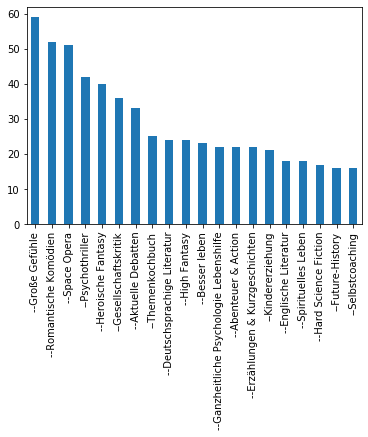

In [23]:
# 3nd level
val_df[[l for l in label_cols if l.startswith('--')]].sum().sort_values(ascending=False)[:20].plot(kind='bar')

In [24]:
# Save with text + labels
#train_df = pd.DataFrame([d.to_df_item(task_labels, True) for d in trainbooks])
#val_df = pd.DataFrame([d.to_df_item(task_labels, True) for d in validationbooks])

# Pickle for later use
with open('germeval_train_df_meta.pickle', 'wb') as f:
    pickle.dump((train_df, doc_cols, label_cols, task1_labels), f)

with open('germeval_val_df_meta.pickle', 'wb') as f:
    pickle.dump((val_df, doc_cols, label_cols, task1_labels), f)
    

#########

# Low Resource: Number of available training data per label

Total labels: 343 / total training samples: 14548
{'1-9': 73, '10-19': 58, '20-29': 36, '30-39': 29, '40-49': 20, '≥ 50': 127}


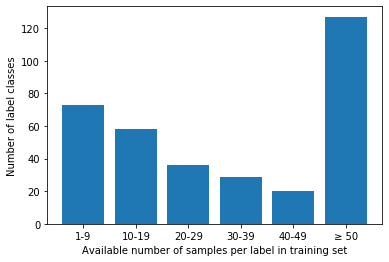

ValueError: If using all scalar values, you must pass an index

In [31]:
task2_labels = label_cols
#task1_labels
len(task2_labels)

print(f'Total labels: {len(task2_labels)} / total training samples: {len(train_df)}')

label2sample_count = {}

groups_f = {
    '1': lambda x: x == 1,
    '< 5': lambda x: 1 < x < 5,
    '< 10': lambda x: 5 <= x < 10,
    '< 25': lambda x: 10 <= x < 25,
    '< 50': lambda x: 25 <= x < 50,
    '< 100': lambda x: 50 <= x < 100,
    '< 250': lambda x: 100 <= x < 250,
    '≥ 250': lambda x: x > 250,
}
groups_f = {
    '1-9': lambda x: 1 <= x < 10,
    '10-19': lambda x: 10 <= x < 20,
    '20-29': lambda x: 20 <= x < 30,
    '30-39': lambda x: 30 <= x < 40,
    '40-49': lambda x: 40 <= x < 50,   
    '≥ 50': lambda x: x >= 50,
    #'50-99': lambda x: 50 <= x < 100,
    #'100-199': lambda x: 100 <= x < 200,
    #'≥ 200': lambda x: x >= 200,
}

groups_v = {v: 0 for v in groups_f}


for label in task2_labels:
    c = sum(train_df[label] == 1)
    label2sample_count[label] = c
    
    for g in groups_f:
        if groups_f[g](c):
            if g in groups_v:
                groups_v[g] += 1
            else:
                groups_v[g] = 1
                
        
print(groups_v)
#print(groups_v['1'] + groups_v['< 5'] + groups_v['< 10'])

plt.bar(groups_v.keys(), groups_v.values(), align='center')
plt.xticks(list(groups_v.keys()))
plt.ylabel('Number of label classes')
plt.xlabel('Available number of samples per label in training set')
#plt.title('Programming language usage')
plt.savefig('samples_per_labels.pdf')
plt.show()

pd.DataFrame.from_dict(groups_v)

# Do author stick to their genre?

In [31]:
author2labels = {}  # name => set(labels)

#for idx, row in pd.concat([train_df, val_df]).iterrows():
#    for author in row['author'].split(';'):
#        if author not in author2labels:
#

for b in trainbooks:
    for a in b.authors:
        if a not in author2labels:
            author2labels[a] = set()
            
        author2labels[a].add('/'.join(list(b.categories.keys())))
        


In [32]:
author2labels

{'Noah Gordon': {'Literatur & Unterhaltung,Historische Romane',
  'Literatur & Unterhaltung,Romane & Erzählungen'},
 'Raymond Feist': {'Literatur & Unterhaltung,Fantasy',
  'Literatur & Unterhaltung,Fantasy,Heroische Fantasy',
  'Literatur & Unterhaltung,Fantasy,High Fantasy'},
 'Susanne Weingarten': {'Ratgeber,Lebenshilfe & Psychologie,Besser leben'},
 'J. Kenner': {'Literatur & Unterhaltung,Erotik',
  'Literatur & Unterhaltung,Romance,Erotik',
  'Literatur & Unterhaltung,Romance,Frauenunterhaltung,Erotik'},
 'Karl May': {'Kinderbuch & Jugendbuch,Literatur & Unterhaltung,Romane & Erzählungen',
  'Literatur & Unterhaltung,Krimi & Thriller,Abenteuer & Action,Romane & Erzählungen',
  'Literatur & Unterhaltung,Romane & Erzählungen',
  'Literatur & Unterhaltung,Romane & Erzählungen,Klassiker & Lyrik,Sachbuch,Kabarett & Satire'},
 'Ana Kraš': {'Künste,Fotografie'},
 'Rolf Bauerdick': {'Literatur & Unterhaltung,Romane & Erzählungen,Deutschsprachige Literatur',
  'Sachbuch,Abenteuer, Reisen, 

In [39]:
#global task1label2pos
#global task1pos2label

task1label2pos = {}
task1pos2label = {}

for i, l in enumerate(task1labels):
    task1label2pos[l] = i
    task1pos2label[i] = l
train_m = getMatrix(trainbooks)
validation_m = getMatrix(validationbooks)


headers = ['blurb'] + [task1pos2label[x] for x in sorted(task1pos2label.keys())]
train_df = pd.DataFrame(train_m, columns=headers)
val_df = pd.DataFrame(validation_m, columns=headers)


print('INFO: Preprocessing data... completed\n')

INFO: Preprocessing data... completed



In [33]:
train_df.head()

,-(Zeit-) Geschichte,--(Zeit-) Geschichte Andere Länder & Kulturen,--19./20. Jahrhundert,--21. Jahrhundert,--50 plus,--Abenteuer & Action,--Abenteuer-Fantasy,"--Abschied, Trauer, Neubeginn",--Afrikanische Literatur,--Agenten-/Spionage-Thriller,...,isbn,publish_date,text,text_words,text_words_10,title,title_words,word_len_max,word_len_mean,word_len_median
0,0,0,0,0,0,0,0,0,0,0,...,9783641136291,2013-12-02,Ein Blick hinter die Kulissen eines Krankenhau...,78,8,Die Klinik,2,18,6.0,5.0
1,0,0,0,0,0,0,0,0,0,0,...,9783641185787,2016-06-20,Die Bedrohungen für Midkemia und Kelewan wolle...,67,7,Die Erben von Midkemia 4,5,14,6.0,6.0
2,0,0,0,0,0,0,0,0,0,0,...,9783328103646,2019-01-14,In der Dreizimmerwohnung stapeln sich Flohmark...,88,9,Völlig losgelöst,2,17,6.0,4.0
3,0,0,0,0,0,0,0,0,0,0,...,9783453357792,2014-04-14,An der Seite von Damien fühlt sich Nikki zum e...,67,7,Dich erfüllen,2,16,6.0,5.0
4,0,0,0,0,0,0,0,0,0,0,...,9783844504958,2007-08-13,"Wer Kara Ben Nemsi, Hadschi Halef Omar und Sir...",88,9,Der Orientzyklus,2,20,6.0,5.0


In [25]:
val_df.head()

,blurb,Künste,Ratgeber,Ganzheitliches Bewusstsein,Kinderbuch & Jugendbuch,Glaube & Ethik,Literatur & Unterhaltung,Sachbuch,Architektur & Garten
0,Die Konfirmandenzeit wird für Jugendliche beso...,0,0,0,0,1,0,0,0
1,Als Morgan von einer prophetischen Vision heim...,0,0,0,1,0,0,0,0
2,Antero Moreira de Mendonca hasst die Jesuiten....,0,0,0,0,0,1,0,0
3,Klar und verständlich führt der Dalai Lama in ...,0,0,1,0,1,0,0,0
4,"Es ist ein Jahr vergangen, seit die 12-jährige...",0,0,0,0,0,1,0,0


In [147]:
# Pickle for later use
with open('germeval_train_df.pickle', 'wb') as f:
    pickle.dump(train_df, f)

with open('germeval_val_df.pickle', 'wb') as f:
    pickle.dump(val_df, f)

In [45]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def removeStopWords(sentence, re_stop_words):
    if sentence is not None and len(sentence) > 0:
        return re_stop_words.sub(" ", sentence)
    else:
        print('WARNING: null sentence')
        return ''

def stemming(sentence, stemmer):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [28]:
#nlp = spacy.load('de') 
nlp = spacy.load('de_core_news_md')  # sm models don’t ship with word vectors
tok = spacy.lang.de.German().Defaults.create_tokenizer(nlp)
stopwords = nlp.Defaults.stop_words
re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)
stemmer = SnowballStemmer("german")



In [46]:

train_df['clean_blurb'] = train_df['blurb']\
    .apply(lambda x: stemming(x, stemmer))\
    .apply(lambda x: removeStopWords(x, re_stop_words))\
    .apply(lambda x: cleanPunc(x))

val_df['clean_blurb'] = val_df['blurb']\
    .apply(lambda x: stemming(x, stemmer))\
    .apply(lambda x: removeStopWords(x, re_stop_words))\
    .apply(lambda x: cleanPunc(x))


In [47]:
def displayInfo1(df):

    categories = list(df.iloc[:,1:].columns.values)
    sns.set(font_scale = 1)
    plt.figure(figsize=(15,8))

    #ax= sns.barplot(categories, df.iloc[:,2:].sum().values)
    ax= sns.barplot(categories, df.iloc[:,1:].sum().values)
    
    plt.title("Blurbs in each category", fontsize=24)
    plt.ylabel('Number of blurbs', fontsize=18)
    plt.xlabel('Blurb Type ', fontsize=18)

    #adding the text labels
    rects = ax.patches
    labels = df.iloc[:,1:].sum().values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

    plt.show()

In [50]:
def displayInfo2(df):

    # note to self: if we want to include this plot in the paper, guess it would be nicer to also include single-label blurbs (currently it seems to display only those blurbs having multiple labels)

    rowSums = df.iloc[:,1:].sum(axis=1)
    multiLabel_counts = rowSums.value_counts()
    multiLabel_counts = multiLabel_counts.iloc[1:]

    sns.set(font_scale = 1)
    plt.figure(figsize=(15,8))

    ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

    plt.title("Blurbs having multiple labels ")
    plt.ylabel('Number of blurbs', fontsize=18)
    plt.xlabel('Number of labels', fontsize=18)

    #adding the text labels
    rects = ax.patches
    labels = multiLabel_counts.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

    plt.show()

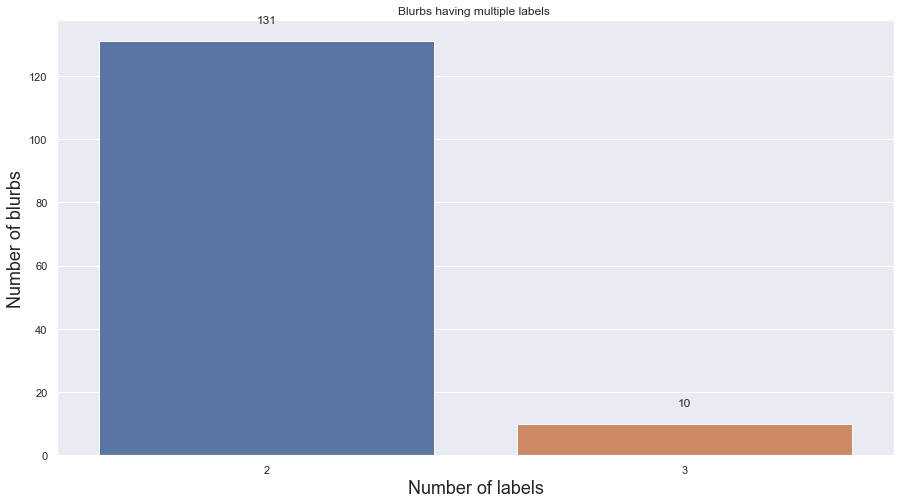

In [52]:
#displayInfo1(val_df)  # does not work

displayInfo2(val_df)


# Baseline

    Seems like there is no randomness anywhere: ran fit and predict 10 times, 10 times the exact same value:
    INFO: Average weighted f1 over 10 runs: 0.729600

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,4), norm='l2', max_features=10000)

#train_x = train_df.blurb
train_x = train_df.clean_blurb

train_y = train_df.iloc[:,1:-1]
#val_x = val_df.blurb
val_x = val_df.clean_blurb

val_y = val_df.iloc[:,1:-1]

vectorizer.fit(train_x)
vectorizer.fit(val_x)

x_train = vectorizer.transform(train_x)
y_train = train_y

x_val = vectorizer.transform(val_x)
y_val = val_y


In [84]:
val_y[:1]

,Künste,Ratgeber,Ganzheitliches Bewusstsein,Kinderbuch & Jugendbuch,Glaube & Ethik,Literatur & Unterhaltung,Sachbuch,Architektur & Garten
0,0,0,0,0,1,0,0,0


In [61]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression#SGDClassifier

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression(solver='lbfgs'))

print('INFO: Training classifier...\n')

INFO: Training classifier...



In [76]:
np.random.seed(None)

In [77]:
fscores = []
numIterations = 10
for i in range(numIterations):
    print('INFO: Running iteration %d...\n' % (i+1))    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_val)
    f1 = f1_score(y_val,predictions, average='weighted')
    print('INFO: weighted f1: %f\n' % f1)
    fscores.append(f1)

print('INFO: Average weighted f1 over %d runs: %f\n' % (numIterations, (np.mean(fscores))))

INFO: Running iteration 1...



/Users/maos01/miniconda3/envs/text-classification/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO: weighted f1: 0.660669

INFO: Running iteration 2...



/Users/maos01/miniconda3/envs/text-classification/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO: weighted f1: 0.660669

INFO: Running iteration 3...



KeyboardInterrupt: 

INFO: weighted f1: 0.660669

# Test data

### Sample submission

```
# filename: Funtastic4__SVM_NAIVEBAYES_ensemble1.txt
subtask_a
9783809436690	Literatur & Unterhaltung
9783453702653	Literatur & Unterhaltung
9783453407343	Ratgeber
9783424631388	Literatur & Unterhaltung
9783641058142	Literatur & Unterhaltung
subtask_b
9783809436690	Literatur & Unterhaltung	Romane & Erzählungen
...
```

In [43]:
# join train + dev
fulltrain_books, task_labels = parseXML(os.path.join(DATASET_DIR, 'blurbs_train_and_dev.txt'))


# test without labels
test_books, _ = parseXML(os.path.join(DATASET_DIR, 'blurbs_test_nolabel.txt'))


In [44]:
with_text = True

task1_labels = [label for label, level in task_labels.items() if level == 0]

doc_cols = list(fulltrain_books[0].to_df_item(with_text).keys())
label_cols = list(fulltrain_books[0].to_df_item_labels(task_labels).keys())

fulltrain_df = pd.DataFrame([{**d.to_df_item(with_text), **d.to_df_item_labels(task_labels)} for d in fulltrain_books])
test_df = pd.DataFrame([{**d.to_df_item(with_text), **d.to_df_item_labels(task_labels)} for d in test_books])

fulltrain_df = fulltrain_df.reindex(columns=doc_cols + label_cols)
test_df = test_df.reindex(columns=doc_cols)

test_df.head()

,isbn,title,title_words,author_count,authors,authors_academic,copyright,publish_date,age,text_words,text_words_10,word_len_mean,word_len_median,word_len_max,text
0,9783809436690,Malbuch für 365 Tage,4,1,_,0,(c) Verlagsgruppe Random House GmbH,2016-10-03,3,56,6,6.0,6.0,13,Ausmalen bringt Freude und entspannt. Dieses m...
1,9783453702653,Ansteckende Gesundheit,2,1,Horst Krohne,0,(c) Verlagsgruppe Random House GmbH,2014-11-10,5,62,6,7.0,6.0,24,Die Beliebtheit der Geistheilung als Alternati...
2,9783453407343,Karibu heißt willkommen,3,1,Stefanie Zweig,0,(c) Verlagsgruppe Random House GmbH,2010-04-06,9,53,5,5.0,5.0,14,Die englische Farmerstochter Stella und das Ki...
3,9783442742394,Mein letzter Versuch die Welt zu retten,7,1,Jo Lendle,0,(c) Verlagsgruppe Random House GmbH,2011-07-11,8,107,11,5.0,4.0,16,"Stell dir vor, es ist Demo und keiner geht hin..."
4,9783734104275,Das saphirblaue Zimmer,3,3,Karen White;Beatriz Williams;Lauren Willig,0,(c) Verlagsgruppe Random House GmbH,2017-09-18,2,97,10,6.0,5.0,16,Manhattan 1945: Die junge Ärztin Kate Schuyler...


In [45]:
# Pickle for later use
with open('germeval_fulltrain_df_meta.pickle', 'wb') as f:
    pickle.dump((fulltrain_df, doc_cols, label_cols, task1_labels), f)

with open('germeval_test_df_meta.pickle', 'wb') as f:
    pickle.dump((test_df, doc_cols, label_cols, task1_labels), f)
    


In [9]:
# authors to file: external script with retrieve additional author info
authors = list(fulltrain_df['authors'].values) + list(test_df['authors'].values)  # TODO test data
with open('authors.pickle', 'wb') as f:
    # list -> ; delmitted str
    pickle.dump(authors, f)
    
# without test: 16627
len(authors)

20784

In [10]:
authors[:10]

['Noah Gordon',
 'Raymond Feist',
 'Susanne Weingarten',
 'J. Kenner',
 'Karl May',
 'Ana Kraš',
 'Rolf Bauerdick',
 'Cynthia Barcomi;Ulf Meyer zu Kueingdorf',
 'Nicholas Sparks',
 'Gene DeWeese']